In [1]:
from fastbook import *

/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [14]:
!pip install bing-image-downloader

In [15]:
from bing_image_downloader import downloader

In [ ]:
downloader.download("grizzly bear", limit=150, output_dir='bears', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("black bear", limit=150, output_dir='bears', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("teddy bear", limit=150, output_dir='bears', adult_filter_off=True, force_replace=False, timeout=5)

In [12]:
Path('bears/grizzly bear').rename('bears/grizzly')
Path('bears/black bear').rename('bears/black')
Path('bears/teddy bear').rename('bears/teddy')

Path('bears/teddy')

In [3]:
path = Path('bears')
fns = get_image_files(path)
fns

(#450) [Path('bears/black/Image_38.jpg'),Path('bears/black/Image_127.jpg'),Path('bears/black/Image_133.jpg'),Path('bears/black/Image_72.jpg'),Path('bears/black/Image_87.jpg'),Path('bears/black/Image_7.jpg'),Path('bears/black/Image_6.jpg'),Path('bears/black/Image_29.jpg'),Path('bears/black/Image_5.jpg'),Path('bears/black/Image_86.jpg')...]

In [4]:
failed = verify_images(fns)
failed

(#0) []

In [5]:
failed.map(Path.unlink)

(#0) []

In [6]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [7]:
parent_label(fns[0])

'black'

In [8]:
bears

In [9]:
path = Path('bears')
dls = bears.dataloaders(path)

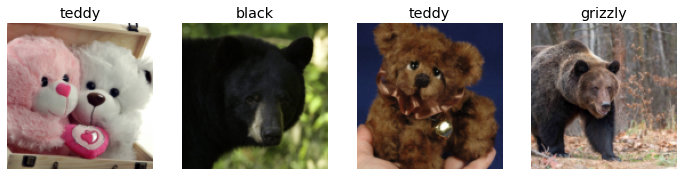

In [10]:
dls.train.show_batch(max_n=4, nrows=1)

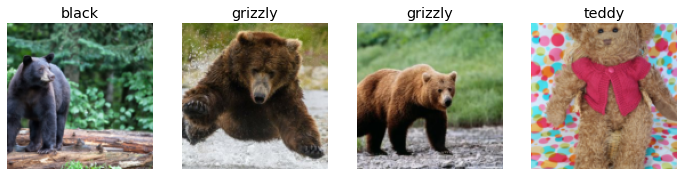

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

In [12]:
bears

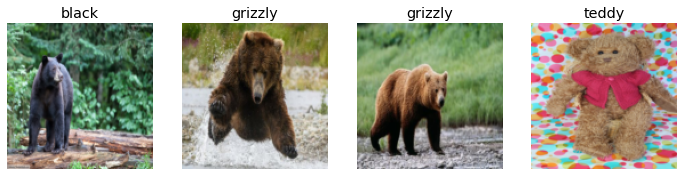

In [14]:
bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

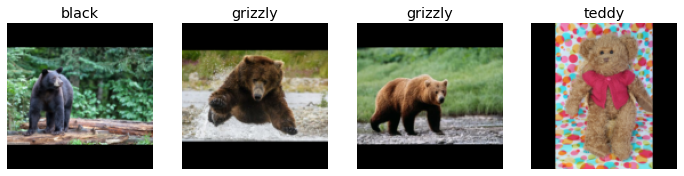

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

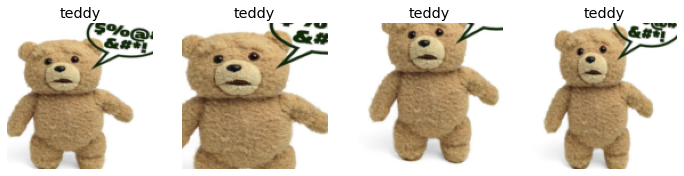

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

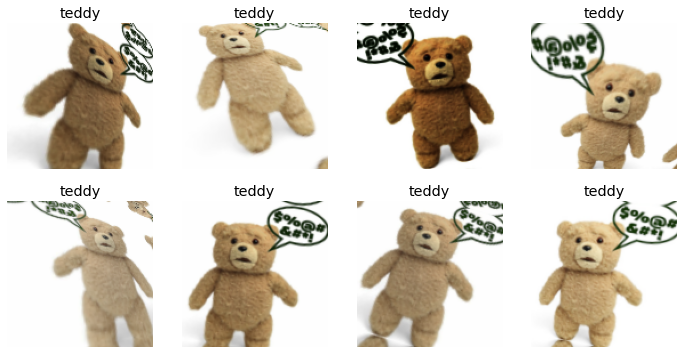

In [25]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

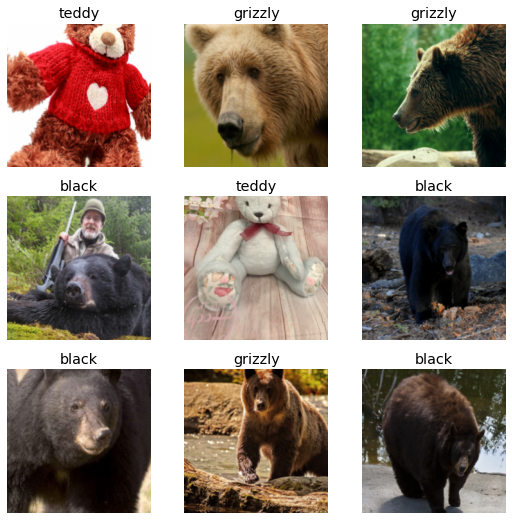

In [39]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch()

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.651691,0.072764,0.011236,00:06


/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.238314,0.032840,0.011236,00:07
1,0.168536,0.042291,0.011236,00:07
2,0.123299,0.064509,0.033708,00:06
3,0.101672,0.056201,0.033708,00:06


/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA

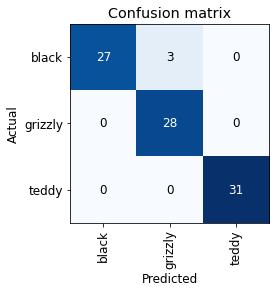

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

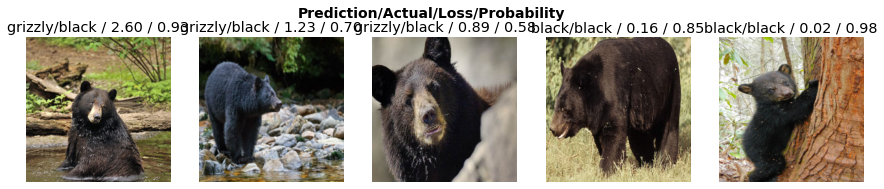

In [42]:
interp.plot_top_losses(5, nrows=1)

In [36]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/koichiro_mori/.pyenv/versions/3.8.6/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [37]:
cleaner.delete()

(#1) [0]

In [38]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [43]:
learn.export()

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [45]:
learn_inf = load_learner(path / 'export.pkl')
learn_inf

In [49]:
learn_inf.predict('bears/grizzly/Image_1.jpg')

('grizzly', tensor(1), tensor([2.6543e-05, 9.9994e-01, 3.3100e-05]))

In [52]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Web Application

In [77]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [82]:
out_pl = widgets.Output()

In [83]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [84]:
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)

In [85]:
VBox([widgets.Label('Select your bear!'),
      btn_upload,
      btn_run,
      out_pl,
      lbl_pred])

In [ ]:
!pip install voila

In [ ]:
!jupyter-lab --VoilaConfiguration.enable_nbextensions=True

In [88]:
!jupyter serverextension enable voila --user

Enabling: voila
- Writing config: /home/koichiro_mori/.jupyter
    - Validating...
      voila 0.2.7 OK
